In [1]:
# Core libraries
import os
import random
import numpy as np
import pandas as pd

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# TorchVision
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18

# Visualisation
import matplotlib.pyplot as plt

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [2]:
import matplotlib.pyplot as plt

# Universal Black-red-white theme
plt.rcParams.update({
    "figure.facecolor": "black",
    "axes.facecolor": "black",
    "axes.edgecolor": "#ff3333",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "text.color": "white",
    "figure.autolayout": True,
    "axes.titleweight": "bold",
    "axes.titlecolor": "white",
    "grid.color": "#444444",
})

In [3]:
# Directory structure
BASE_DIR = "explaining_vision_without_understanding"
FIG_DIR = os.path.join(BASE_DIR, "figures")
CKPT_DIR = os.path.join(BASE_DIR, "checkpoints")

os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(CKPT_DIR, exist_ok=True)

print("Project folders ready.")


Project folders ready.


In [4]:
# Data transforms
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465),
        std=(0.2023, 0.1994, 0.2010)
    )
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465),
        std=(0.2023, 0.1994, 0.2010)
    )
])

# Load datasets
train_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform_train
)

test_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transform_test
)

# Data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=2
)

classes = train_dataset.classes
print("Classes:", classes)


100%|██████████| 170M/170M [00:03<00:00, 46.7MB/s]


Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [5]:
# Load ResNet-18
model = resnet18(pretrained=False)

# Modify final layer for CIFAR-10
model.fc = nn.Linear(model.fc.in_features, 10)

model = model.to(device)
print(model)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
# Loss and optimiser
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(
    model.parameters(),
    lr=0.1,
    momentum=0.9,
    weight_decay=5e-4
)

scheduler = optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=[60, 120],
    gamma=0.2
)


In [7]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    return running_loss / len(loader), accuracy


In [8]:
def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    return running_loss / len(loader), accuracy


In [10]:
NUM_EPOCHS = 150
PATIENCE = 15  # number of epochs to wait without improvement

history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

best_acc = 0.0
epochs_without_improvement = 0

for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_one_epoch(
        model, train_loader, optimizer, criterion
    )

    val_loss, val_acc = evaluate(
        model, test_loader, criterion
    )

    scheduler.step()

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    # Check for improvement
    if val_acc > best_acc:
        best_acc = val_acc
        epochs_without_improvement = 0

        torch.save(
            model.state_dict(),
            os.path.join(CKPT_DIR, "best_resnet18_cifar10.pth")
        )
    else:
        epochs_without_improvement += 1

    if epoch % 10 == 0:
        print(
            f"Epoch [{epoch}/{NUM_EPOCHS}] | "
            f"Train Acc: {train_acc:.2f}% | "
            f"Val Acc: {val_acc:.2f}% | "
            f"No Improve: {epochs_without_improvement}"
        )

    # Early stopping condition
    if epochs_without_improvement >= PATIENCE:
        print(
            f"Early stopping triggered at epoch {epoch}. "
            f"Best Val Acc: {best_acc:.2f}%"
        )
        break

print("Training complete. Best accuracy:", best_acc)


Epoch [0/150] | Train Acc: 77.16% | Val Acc: 75.98% | No Improve: 0
Epoch [10/150] | Train Acc: 84.07% | Val Acc: 83.95% | No Improve: 0
Epoch [20/150] | Train Acc: 87.71% | Val Acc: 84.12% | No Improve: 3
Epoch [30/150] | Train Acc: 87.88% | Val Acc: 83.56% | No Improve: 13
Early stopping triggered at epoch 32. Best Val Acc: 84.78%
Training complete. Best accuracy: 84.78


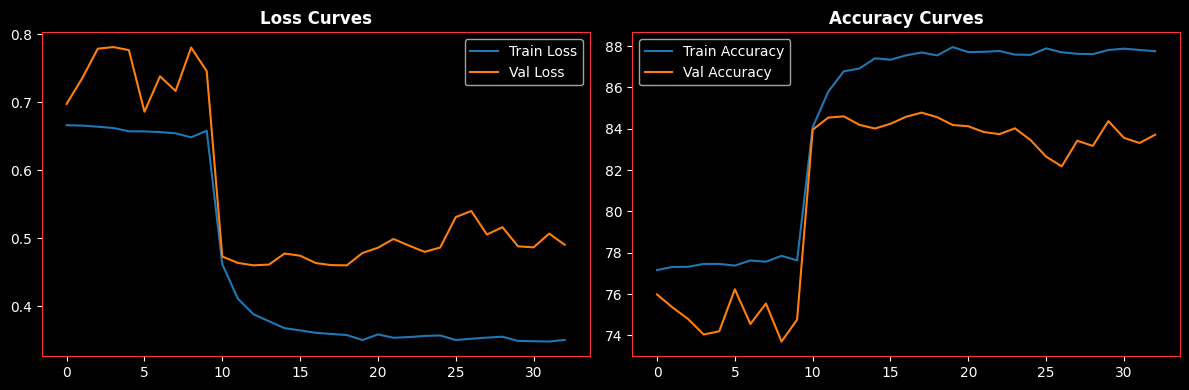

In [11]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss Curves")

plt.subplot(1,2,2)
plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["val_acc"], label="Val Accuracy")
plt.legend()
plt.title("Accuracy Curves")

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "training_curves.png"))
plt.show()


In [12]:
# Load best model checkpoint
model.load_state_dict(
    torch.load(os.path.join(CKPT_DIR, "best_resnet18_cifar10.pth"), map_location=device)
)

model.eval()

# Freeze model parameters (important for explainability)
for param in model.parameters():
    param.requires_grad = False

print("Loaded best model. Model frozen for explainability.")


Loaded best model. Model frozen for explainability.


In [13]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = output.argmax(dim=1)

        score = output[:, class_idx]
        score.backward(retain_graph=True)

        # Global average pooling of gradients
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)

        cam = torch.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)

        return cam


In [14]:
# Target last convolutional block
target_layer = model.layer4[-1]

gradcam = GradCAM(model, target_layer)


In [15]:
import cv2
import numpy as np

def denormalize(img):
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    img = img * std + mean
    return np.clip(img, 0, 1)

def overlay_cam(image, cam, alpha=0.5):
    cam = cv2.resize(cam, (image.shape[1], image.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = heatmap[:, :, ::-1] / 255.0
    return np.clip((1 - alpha) * image + alpha * heatmap, 0, 1)


In [18]:
import matplotlib.pyplot as plt

def show_gradcam_examples(model, dataloader, gradcam, num_images=6):
    model.eval()
    images_shown = 0

    plt.figure(figsize=(12, 8))

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        # Enable gradients ONLY for explainability
        images.requires_grad_()

        outputs = model(images)
        preds = outputs.argmax(dim=1)

        for i in range(images.size(0)):
            if images_shown >= num_images:
                plt.show()
                return

            # Prepare image for display
            img = images[i].detach().cpu().permute(1, 2, 0).numpy()
            img = denormalize(img)

            # Generate Grad-CAM for the predicted class
            cam = gradcam.generate(
                images[i].unsqueeze(0),
                class_idx=preds[i].unsqueeze(0)
            )
            cam = cam.squeeze().cpu().numpy()

            overlay = overlay_cam(img, cam)

            plt.subplot(2, num_images // 2, images_shown + 1)
            plt.imshow(overlay)
            plt.title(f"Pred: {preds[i].item()} | True: {labels[i].item()}")
            plt.axis("off")

            images_shown += 1


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


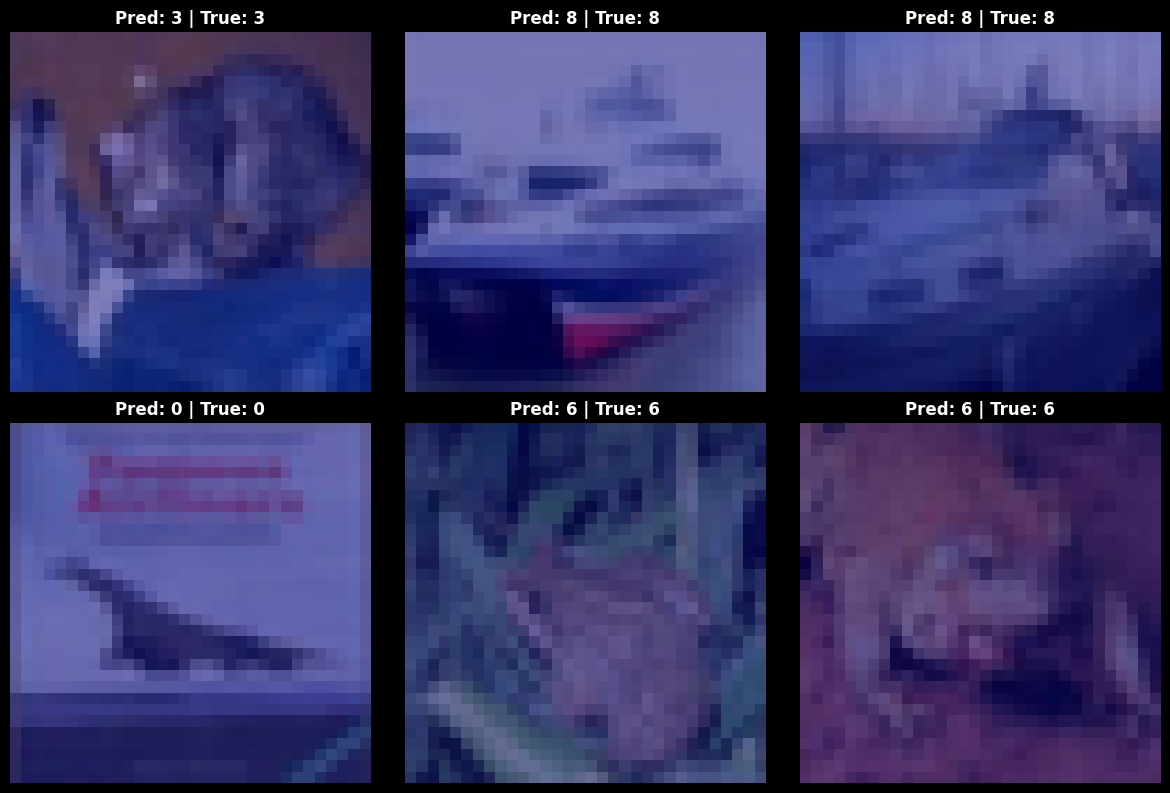

In [20]:
show_gradcam_examples(model, test_loader, gradcam, num_images=6)

In [22]:
from captum.attr import IntegratedGradients

In [23]:
ig = IntegratedGradients(model)

In [24]:
def compute_ig_attribution(model, ig, input_tensor, target_class, steps=50):
    model.zero_grad()

    attributions = ig.attribute(
        input_tensor,
        target=target_class,
        n_steps=steps,
        internal_batch_size=steps
    )

    # Aggregate across channels
    attributions = attributions.abs().mean(dim=1)

    # Normalize
    attributions = attributions - attributions.min()
    attributions = attributions / (attributions.max() + 1e-8)

    return attributions


In [27]:
def compare_explanations(model, dataloader, gradcam, ig, num_images=4):
    model.eval()
    shown = 0

    plt.figure(figsize=(12, 9))

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        # Enable gradients ONLY for explainability
        images.requires_grad_()

        outputs = model(images)
        preds = outputs.argmax(dim=1)

        for i in range(images.size(0)):
            if shown >= num_images:
                plt.show()
                return

            # ---- Original image (safe conversion) ----
            img = images[i].detach().cpu().permute(1, 2, 0).numpy()
            img = denormalize(img)

            # ---- Grad-CAM ----
            cam = gradcam.generate(
                images[i].unsqueeze(0),
                class_idx=preds[i].unsqueeze(0)
            )
            cam = cam.detach().squeeze().cpu().numpy()

            cam_overlay = overlay_cam(img, cam)

            # ---- Integrated Gradients ----
            ig_attr = compute_ig_attribution(
                model,
                ig,
                images[i].unsqueeze(0),
                preds[i].item()
            )
            ig_attr = ig_attr.detach().squeeze().cpu().numpy()

            ig_overlay = overlay_cam(img, ig_attr)

            # ---- Plot ----
            plt.subplot(num_images, 3, shown * 3 + 1)
            plt.imshow(img)
            plt.title("Original")
            plt.axis("off")

            plt.subplot(num_images, 3, shown * 3 + 2)
            plt.imshow(cam_overlay)
            plt.title("Grad-CAM")
            plt.axis("off")

            plt.subplot(num_images, 3, shown * 3 + 3)
            plt.imshow(ig_overlay)
            plt.title("Integrated Gradients")
            plt.axis("off")

            shown += 1


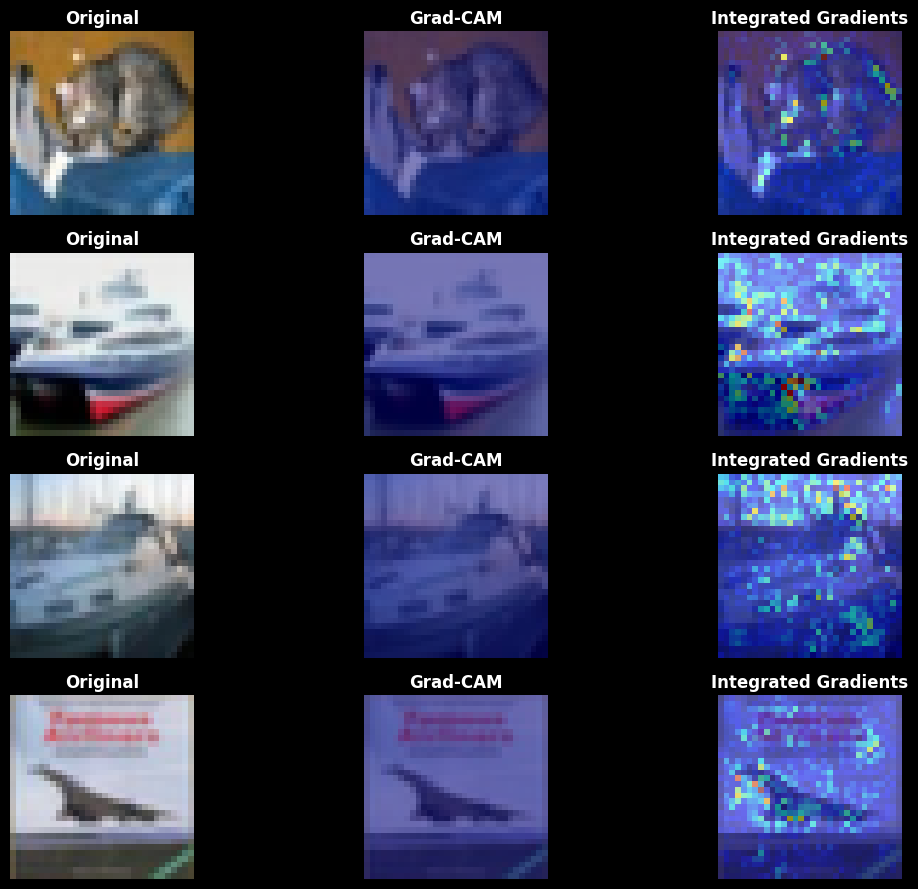

In [28]:
compare_explanations(model, test_loader, gradcam, ig, num_images=4)

In [29]:
def deletion_curve(model, image, attribution, steps=20):
    model.eval()

    _, _, h, w = image.shape
    scores = []

    # Flatten attribution
    flat_attr = attribution.view(-1)
    indices = torch.argsort(flat_attr, descending=True)

    image_flat = image.view(-1)

    for k in torch.linspace(0, len(indices), steps).int():
        masked = image_flat.clone()
        masked[indices[:k]] = 0.0
        masked = masked.view(1, 3, h, w)

        with torch.no_grad():
            output = model(masked)
            score = output.max(dim=1)[0].item()
            scores.append(score)

    return scores


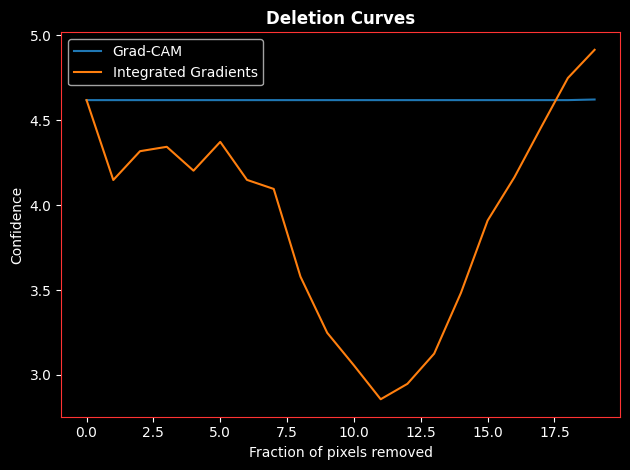

In [30]:
images, labels = next(iter(test_loader))
images = images.to(device)
images.requires_grad_()

outputs = model(images)
pred = outputs.argmax(dim=1)[0]

# Grad-CAM attribution
cam = gradcam.generate(images[0].unsqueeze(0), pred.unsqueeze(0))
cam = cam.view(-1)

# IG attribution
ig_attr = compute_ig_attribution(model, ig, images[0].unsqueeze(0), pred)
ig_attr = ig_attr.view(-1)

cam_scores = deletion_curve(model, images[0].unsqueeze(0), cam)
ig_scores = deletion_curve(model, images[0].unsqueeze(0), ig_attr)

plt.plot(cam_scores, label="Grad-CAM")
plt.plot(ig_scores, label="Integrated Gradients")
plt.xlabel("Fraction of pixels removed")
plt.ylabel("Confidence")
plt.title("Deletion Curves")
plt.legend()
plt.show()


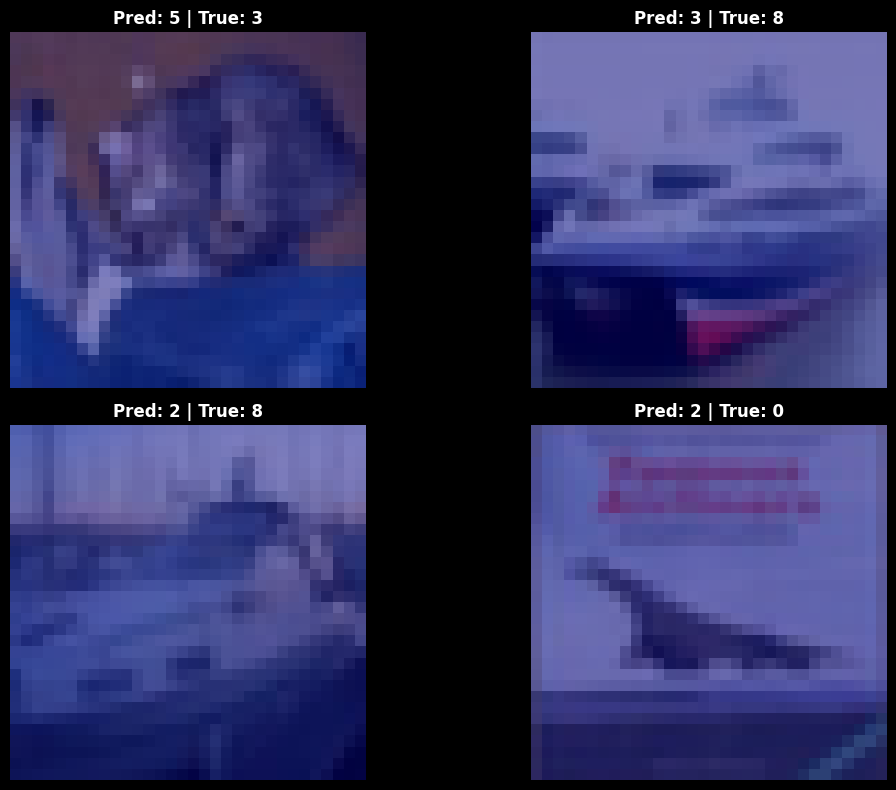

In [32]:
import torchvision.models as models

random_model = models.resnet18(num_classes=10).to(device)
random_model.eval()

random_gradcam = GradCAM(random_model, random_model.layer4[-1])

show_gradcam_examples(
    random_model,
    test_loader,
    random_gradcam,
    num_images=4
)